In [2]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from fredapi import Fred
from sklearn.model_selection import train_test_split

In [3]:
start_date = "2014-01-01"
end_date = "2020-01-01"

df_sptl = yf.download("SPTL", start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [4]:
fred = Fred(api_key="72ac7123eafc45f90a8313da3af63215")

df_effr = fred.get_series("EFFR", observation_start="2014-01-02", observation_end="2019-12-31")

df_effr = pd.DataFrame(df_effr, columns=['Rate'])

dc = 1 / 252

df_effr = df_effr / 100 * dc

merged = pd.merge(df_sptl, df_effr, how='outer', left_index=True, right_index=True)

merged.dropna(inplace=True)
merged.shape

df_effr = merged['Rate']

df_effr
merged

,Open,High,Low,Close,Adj Close,Volume,Rate
2014-01-02,29.924999,30.070000,29.924999,30.055000,23.225666,25400.0,0.000003
2014-01-03,29.959999,30.105000,29.959999,30.035000,23.210217,22000.0,0.000003
2014-01-06,30.110001,30.270000,30.110001,30.160000,23.306812,3200.0,0.000003
2014-01-07,30.240000,30.260000,30.200001,30.260000,23.384089,3800.0,0.000003
2014-01-08,30.075001,30.184999,30.075001,30.150000,23.299074,14800.0,0.000003
...,...,...,...,...,...,...,...
2019-12-24,39.029999,39.330002,39.020000,39.290001,35.547798,164100.0,0.000062
2019-12-26,39.320000,39.400002,39.200001,39.389999,35.638264,242300.0,0.000062
2019-12-27,39.459999,39.509998,39.419998,39.419998,35.665413,155700.0,0.000062
2019-12-30,39.040001,39.310001,38.959999,39.310001,35.565887,523900.0,0.000062


In [5]:
specific_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']  # List of column names to select
df_sptl = merged[specific_columns].copy()

adj_close_sptl = df_sptl['Adj Close']
close_sptl = df_sptl['Close']

In [6]:
# Calculate the daily return of SPTL ETF
sptl_daily_return = adj_close_sptl.pct_change()

print(sptl_daily_return)

# Calculate the daily excess return` per unit of SPTL
daily_excess_return = sptl_daily_return - df_effr

# Display the first few rows of the calculated daily excess return
print(daily_excess_return.head())

train_effr, test_effr = train_test_split(df_effr, test_size = 0.3, shuffle=False)

df_sptl['Ascending_Numbers'] = range(len(df_sptl))
x_days = df_sptl['Ascending_Numbers']

2014-01-02         NaN
2014-01-03   -0.000665
2014-01-06    0.004162
2014-01-07    0.003316
2014-01-08   -0.003636
                ...   
2019-12-24    0.003320
2019-12-26    0.002545
2019-12-27    0.000762
2019-12-30   -0.002791
2019-12-31   -0.011193
Name: Adj Close, Length: 1499, dtype: float64
2014-01-02         NaN
2014-01-03   -0.000668
2014-01-06    0.004159
2014-01-07    0.003313
2014-01-08   -0.003638
dtype: float64


Text(0.09, 0.5, 'Rate (%)')

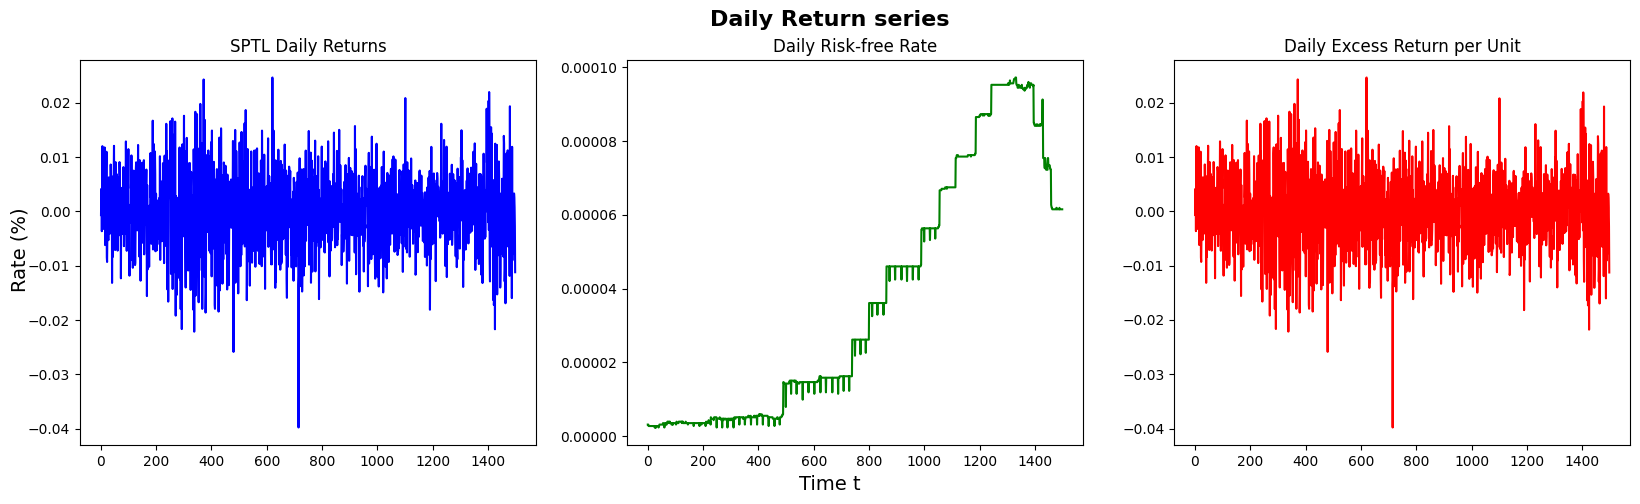

In [7]:
fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

ax1.set_title('SPTL Daily Returns')
ax1.plot(x_days, sptl_daily_return, label='SPTL Return', color='blue')

ax2.set_title('Daily Risk-free Rate')
ax2.plot(x_days, df_effr, label='EFFR', color='green')

ax3.set_title('Daily Excess Return per Unit')
ax3.plot(x_days, daily_excess_return, label='Excess Return', color='red')

plt.suptitle('Daily Return series', fontsize=16, fontweight='bold')
fig.text(0.5, 0.02, 'Time t', ha='center', fontsize=14)
fig.text(0.09, 0.5, 'Rate (%)', va='center', rotation='vertical', fontsize=14)

## Trading Strategies

### SMA Crossover

In [8]:
train_df, test_df = train_test_split(df_sptl, test_size = 0.3, shuffle=False)

train_df = train_df[['Adj Close','Ascending_Numbers']]
test_df = test_df[['Adj Close','Ascending_Numbers']]

train_days = train_df['Ascending_Numbers']
test_days = test_df['Ascending_Numbers']

short_window = 25
long_window = 100

test_df['25_SMA'] = test_df['Adj Close'].rolling(window=short_window, min_periods=1).mean()
test_df['100_SMA'] = test_df['Adj Close'].rolling(window=long_window, min_periods=1).mean()

test_df['Signal'] = 0.0
test_df['Signal'] = np.where(test_df['25_SMA'] > test_df['100_SMA'], 1.0, 0.0)

test_df['Position'] = test_df['Signal'].diff()

Text(0, 0.5, 'Price (USD)')

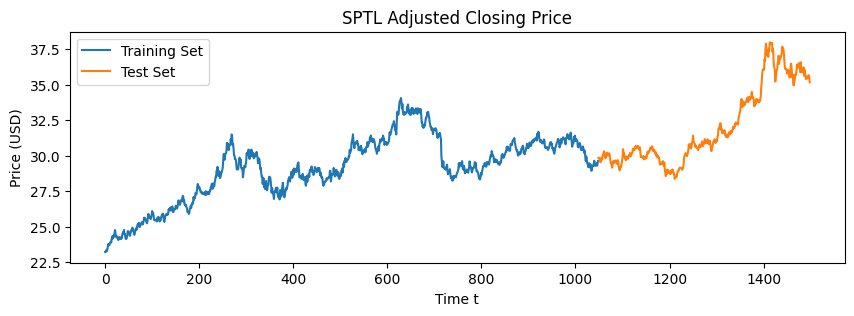

In [9]:
plt.figure(figsize = (10,3))
plt.plot(train_df['Ascending_Numbers'], train_df['Adj Close'], label='Training Set')
plt.plot(test_df['Ascending_Numbers'], test_df['Adj Close'], label='Test Set')
plt.legend()
plt.title('SPTL Adjusted Closing Price')
plt.xlabel('Time t')
plt.ylabel('Price (USD)')

Text(0, 0.5, 'Price (USD)')

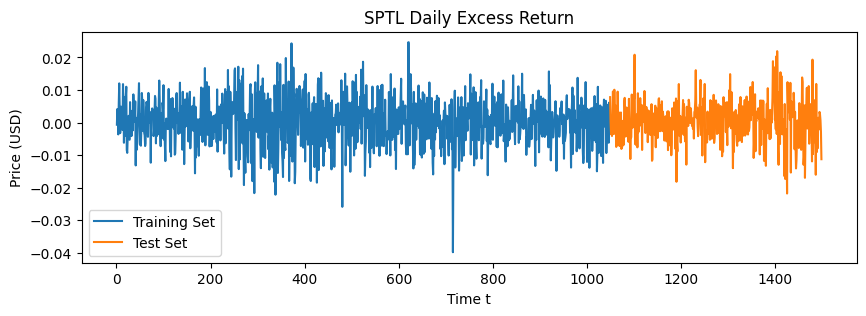

In [10]:
der_train, der_test = train_test_split(daily_excess_return, test_size = 0.3, shuffle=False)

plt.figure(figsize = (10,3))
plt.plot(train_df['Ascending_Numbers'], der_train, label='Training Set')
plt.plot(test_df['Ascending_Numbers'], der_test, label='Test Set')
plt.legend()
plt.title('SPTL Daily Excess Return')
plt.xlabel('Time t')
plt.ylabel('Price (USD)')

In [11]:
def print_buy_sell(df):
    buy_df = df[df['Position'] == 1.0]
    sell_df = df[df['Position'] == -1.0]

    combined = pd.concat([buy_df, sell_df])
    return combined.sort_index()

combined = print_buy_sell(test_df)


In [12]:
'''
SMA Crossover

When the short term moving average crosses ABOVE the long term moving average, this indicates a buy signal.
When the short term moving average crosses below the long term moving average, it may be a good moment to sell.

When 'Position’ = 1, it implies that the Signal has changed from 0 to 1 meaning a short-term(faster) moving average 
has crossed ABOVE the long-term(slower) moving average, thereby triggering a buy call.

When 'Position’ = -1, it implies that the Signal has changed from 1 to 0 meaning a short-term(faster) moving average 
has crossed BELOW the long-term(slower) moving average, thereby triggering a sell call.
'''

def calculate_units(sptl_data, positions, initial_capital, leverage):
    units = pd.Series(index=sptl_data.index, dtype='float64')
    cash = initial_capital * leverage
    for i, position in enumerate(positions):
        price = sptl_data['Adj Close'].iloc[i]
        if sptl_data['Position'].iloc[i] == 1.0 and cash >= price:
            units.iloc[i] = cash / price
            cash = 0
        elif sptl_data['Position'].iloc[i] == -1.0 and units.iloc[i-1] > 0:
            cash += units.iloc[i-1] * price
            units.iloc[i] = 0
        else: 
            units.iloc[i] = units.iloc[i-1]
    return units


sma_units = calculate_units(test_df, test_df['Signal'], 200000, 10)

sma_units = sma_units.fillna(0)

sma_filtered_units = sma_units.loc[sma_units.index.isin(combined.index)]

print(sma_units)

sma_filtered_prices = test_df['Adj Close'].loc[test_df['Adj Close'].index.isin(sma_filtered_units.index)]

sma_filtered_units_turnover = sma_filtered_units.replace(0, pd.NA).fillna(method='ffill')

print(sma_filtered_prices)
print(sma_filtered_units_turnover)

turnover_value = sma_filtered_units_turnover * sma_filtered_prices

print(turnover_value)
sma_theta_t = sma_units * test_df['Adj Close']

sma_pnl_df = (der_test * sma_theta_t)

print("The turnover in dollar value traded over time: ", turnover_value.sum())

print("The turnover in number of units traded over time: ", sma_filtered_units.sum() * 2)

2018-03-14    0.0
2018-03-15    0.0
2018-03-16    0.0
2018-03-19    0.0
2018-03-20    0.0
             ... 
2019-12-24    0.0
2019-12-26    0.0
2019-12-27    0.0
2019-12-30    0.0
2019-12-31    0.0
Length: 450, dtype: float64
2018-04-19    29.694401
2018-05-04    29.664215
2018-06-20    29.938931
2018-09-26    29.581127
2018-12-19    30.804483
2019-11-18    35.741020
Name: Adj Close, dtype: float64
2018-04-19    67352.765066
2018-05-04    67352.765066
2018-06-20    66734.745548
2018-09-26    66734.745548
2018-12-19    64084.470043
2019-11-18    64084.470043
dtype: float64
2018-04-19    2.000000e+06
2018-05-04    1.997967e+06
2018-06-20    1.997967e+06
2018-09-26    1.974089e+06
2018-12-19    1.974089e+06
2019-11-18    2.290444e+06
dtype: float64
The turnover in dollar value traded over time:  12234556.146844566
The turnover in number of units traded over time:  396343.9613140656


C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\3758348937.py:40: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  sma_filtered_units_turnover = sma_filtered_units.replace(0, pd.NA).fillna(method='ffill')


In [13]:
sma_turnover_df = turnover_value.to_frame()
sma_turnover_df.columns = ['Value']
sma_turnover_df = sma_turnover_df.reindex(sma_units.index)
sma_turnover_df = sma_turnover_df.fillna(0)

sma_units_turnover_df = sma_filtered_units_turnover.to_frame()
sma_units_turnover_df.columns = ['Units']
sma_units_turnover_df = sma_units_turnover_df.reindex(sma_units.index)
sma_units_turnover_df = sma_units_turnover_df.fillna(0)

In [14]:
n_days = len(sma_units)
initial_cash = 200000
leverage = 10

# assets
sma_V_t = np.zeros((n_days,))
sma_delta_V_t = np.zeros((n_days,))

# money market
sma_V_cap = np.zeros((n_days,))
sma_delta_V_cap = np.zeros((n_days,))

# totals
sma_V_total = np.zeros((n_days,))
sma_delta_V_total = np.zeros((n_days,))

# initial values
sma_V_t[0] = initial_cash
sma_delta_V_t[0] = 0
sma_V_cap[0] = 0
sma_delta_V_cap[0] = 0
sma_V_total[0] = sma_V_t[0] + sma_delta_V_cap[0]
sma_delta_V_total[0] = 0

for i, s in enumerate (sma_units[:-1]):
    
    if i == 0:
        continue
        
    # get V_t
    sma_delta_V_t[i] = (der_test[i+1] * sma_theta_t[i]) 
    sma_V_t[i] = sma_delta_V_t[i] + sma_V_t[i-1]
    
    # get V_cap_t
    M = np.abs(sma_theta_t[i]) / leverage
    sma_delta_V_cap[i] = (sma_V_total[i-1] - M) * (test_effr[i+1]) 
    sma_V_cap[i] = sma_delta_V_cap[i] + sma_V_cap[i-1]

    # Get V_total_t
    sma_delta_V_total[i] = sma_pnl_df[i] + sma_delta_V_cap[i]
    sma_V_total[i] = sma_delta_V_total[i] + sma_V_total[i-1]

sma_delta_V_cap = np.abs(sma_delta_V_cap)

C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\4097789823.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sma_delta_V_t[i] = (der_test[i+1] * sma_theta_t[i])
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\4097789823.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M = np.abs(sma_theta_t[i]) / leverage
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\4097789823.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sma_del

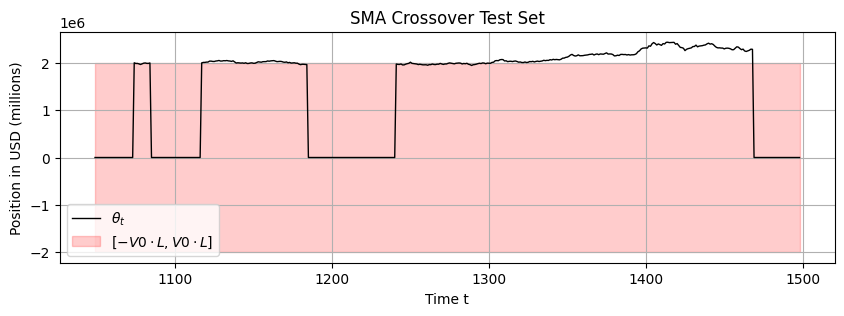

In [15]:
def plot_position_strategy(index, theta_t, title):

    plt.figure(figsize = (10,3))
    plt.plot(index, theta_t, color = 'black', lw = 1, alpha = 1, label = r'$\theta_t$')
    plt.fill_between(index, -10*200000, 10*200000, color = 'red', alpha = 0.2, label = r'$[-V0 \cdot L, V0 \cdot L]$')
    plt.title(title)
    plt.xlabel('Time t')
    plt.ylabel('Position in USD (millions)')
    plt.legend()
    plt.grid(True)
    
plot_position_strategy(test_days, sma_theta_t, "SMA Crossover Test Set")

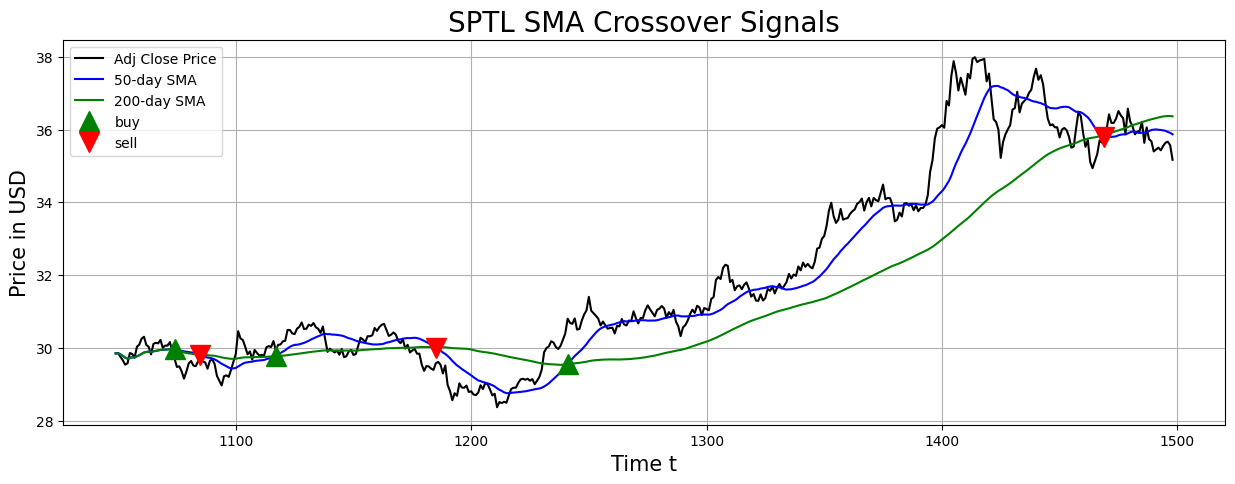

In [16]:
plt.figure(figsize = (15,5))
# plot Adj Close price, short-term and long-term moving averages 
plt.plot(test_days, test_df['Adj Close'], color = 'k', label= 'Adj Close Price')
plt.plot(test_days, test_df['25_SMA'], color = 'b',label = '50-day SMA')
plt.plot(test_days, test_df['100_SMA'], color = 'g', label = '200-day SMA')

# plot 'buy’ signals
plt.plot(test_days[test_df['Position'] == 1], 
         test_df['25_SMA'][test_df['Position'] == 1], 
         '^', markersize = 15, color = 'g', label = 'buy')
# plot 'sell’ signals
plt.plot(test_days[test_df['Position'] == -1], 
         test_df['25_SMA'][test_df['Position'] == -1], 
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in USD', fontsize = 15 )
plt.xlabel('Time t', fontsize = 15 )
plt.title('SPTL SMA Crossover Signals', fontsize = 20)
plt.legend()
plt.grid()
plt.show()

### Bollinger Bands

In [17]:
bb_train_df, bb_test_df = train_test_split(df_sptl, test_size = 0.3, shuffle=False)

bb_train_df = bb_train_df[['Adj Close']]
bb_test_df = bb_test_df[['Adj Close']]

In [18]:
def bollinger_band(price, length = 20, num_stdev = 2):
    mean_price = price.rolling(length).mean()
    stdev = price.rolling(length).std()
    upper_band = mean_price + num_stdev*stdev
    lower_band = mean_price - num_stdev*stdev
 
    return np.round(mean_price, 3), np.round(upper_band, 3),  np.round(lower_band, 3)

bb_test_df['Moving_avg'], bb_test_df['Upper_band'], bb_test_df['Lower_band'] = bollinger_band(bb_test_df['Adj Close'])

bb_test_df.tail()

,Adj Close,Moving_avg,Upper_band,Lower_band
2019-12-24,35.547798,35.919,36.658,35.181
2019-12-26,35.638264,35.876,36.569,35.182
2019-12-27,35.665413,35.840,36.495,35.185
2019-12-30,35.565887,35.803,36.429,35.176
2019-12-31,35.167793,35.767,36.453,35.081


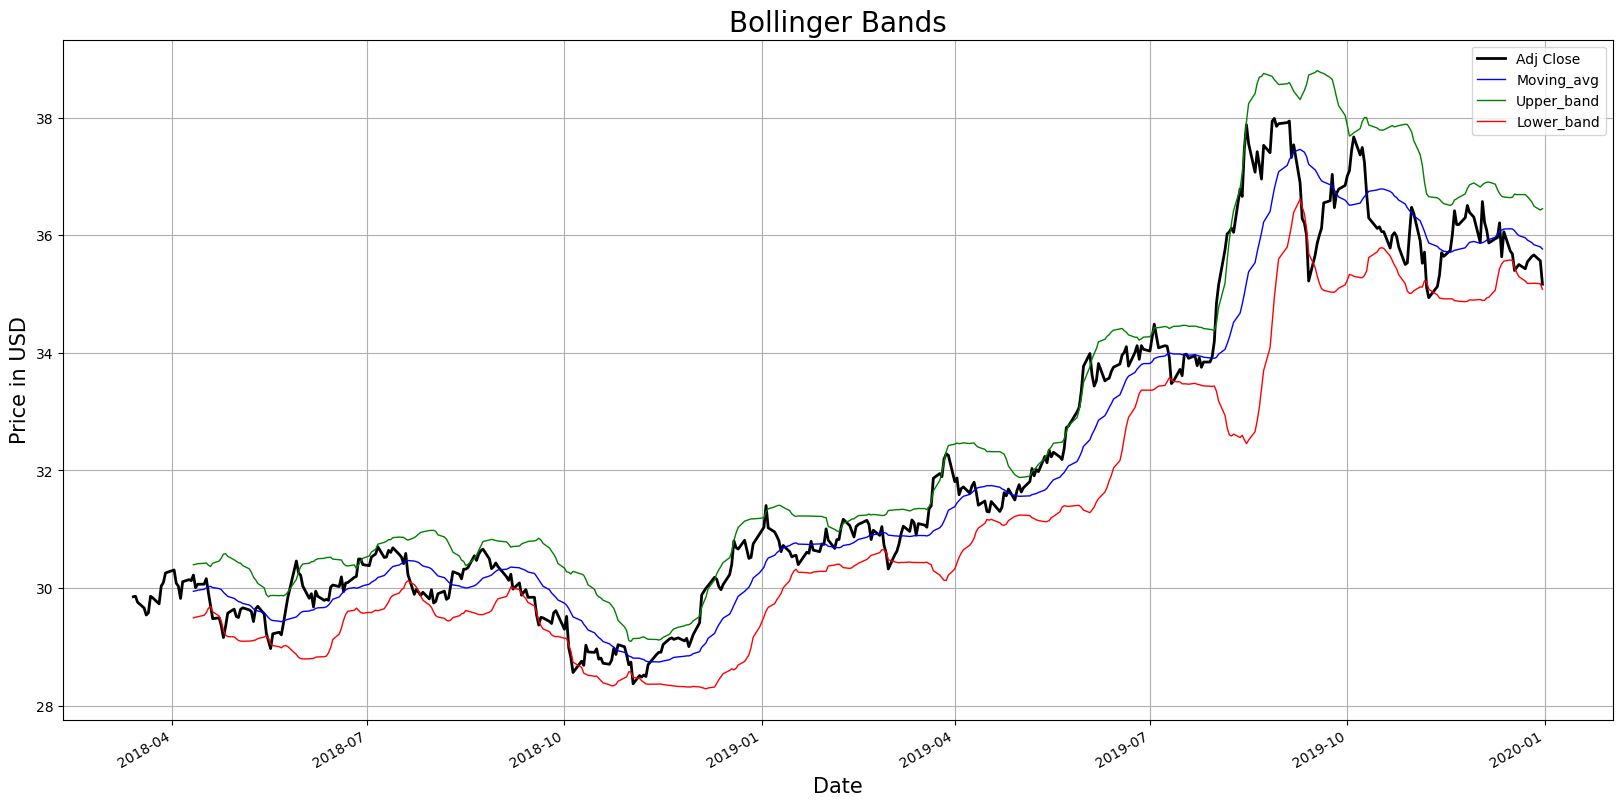

'\nWe can observe that the spaces between the upper and lower bands are becoming narrow or wider \nat different times representing the volatility of the stock (wider == high volatility and vice-versa).\n'

In [19]:
bb_test_df['Adj Close'].plot(c = 'k', figsize = (20,10), lw = 2)
bb_test_df['Moving_avg'].plot(c = 'b', figsize = (20, 10), lw = 1)
bb_test_df['Upper_band'].plot(c = 'g', figsize = (20, 10), lw = 1) 
bb_test_df['Lower_band'].plot(c = 'r', figsize = (20, 10), lw = 1)

plt.title('Bollinger Bands', fontsize = 20)
plt.ylabel('Price in USD',fontsize = 15 )
plt.xlabel('Date', fontsize = 15 )
plt.legend()
plt.grid()
plt.show()

'''
We can observe that the spaces between the upper and lower bands are becoming narrow or wider 
at different times representing the volatility of the stock (wider == high volatility and vice-versa).
'''

In [20]:
'''
shoot a buy signal if the stock price of the previous day is greater than the previous day's lower band
and the current stock price is lesser than the current day’s lower band. 
Similarly, if the stock price of the previous day is lesser than the previous day’s upper band and 
the current stock price is greater than the current day’s upper band, the strategy will reveal a sell signal

The middle band (MA) represents the average price over the specified period and can serve as a reference point.
'''

def bb_strategy(data, lower_bb, upper_bb):
    buy_price = []
    sell_price = []
    bb_signal = []
    signal = 0
    
    for i in range(len(data)):
        if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
            if signal != 1:
                buy_price.append(data[i])
                sell_price.append(np.nan)
                signal = 1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
            if signal != -1:
                buy_price.append(np.nan)
                sell_price.append(data[i])
                signal = -1
                bb_signal.append(signal)
            else:
                buy_price.append(np.nan)
                sell_price.append(np.nan)
                bb_signal.append(0)
        else:
            buy_price.append(np.nan)
            sell_price.append(np.nan)
            bb_signal.append(0)
            
    return buy_price, sell_price, bb_signal

bb_test_df['buy_price'], bb_test_df['sell_price'], bb_test_df['Position'] = bb_strategy(bb_test_df['Adj Close'], bb_test_df['Lower_band'], bb_test_df['Upper_band'])

filtered_bb_test_df = bb_test_df[(bb_test_df['Position'] == -1) | (bb_test_df['Position'] == 1)]

filtered_bb_test_df

C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2420216129.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if data[i-1] > lower_bb[i-1] and data[i] < lower_bb[i]:
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2420216129.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  elif data[i-1] < upper_bb[i-1] and data[i] > upper_bb[i]:
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2420216129.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `

,Adj Close,Moving_avg,Upper_band,Lower_band,buy_price,sell_price,Position
2018-04-20,29.478407,30.009,30.423,29.596,29.478407,NaN,1
2018-05-29,30.460806,29.509,30.148,28.871,NaN,30.460806,-1
2018-07-23,29.893534,30.459,30.858,30.059,29.893534,NaN,1
2018-08-20,30.548977,30.039,30.501,29.577,NaN,30.548977,-1
2018-09-07,29.983122,30.354,30.707,30.002,29.983122,NaN,1
2018-12-04,29.884535,28.993,29.678,28.309,NaN,29.884535,-1
2019-02-28,30.595253,30.935,31.255,30.614,30.595253,NaN,1
2019-03-22,31.868216,30.973,31.652,30.295,NaN,31.868216,-1
2019-07-11,33.477886,33.991,34.432,33.549,33.477886,NaN,1
2019-08-01,34.840561,33.925,34.502,33.348,NaN,34.840561,-1


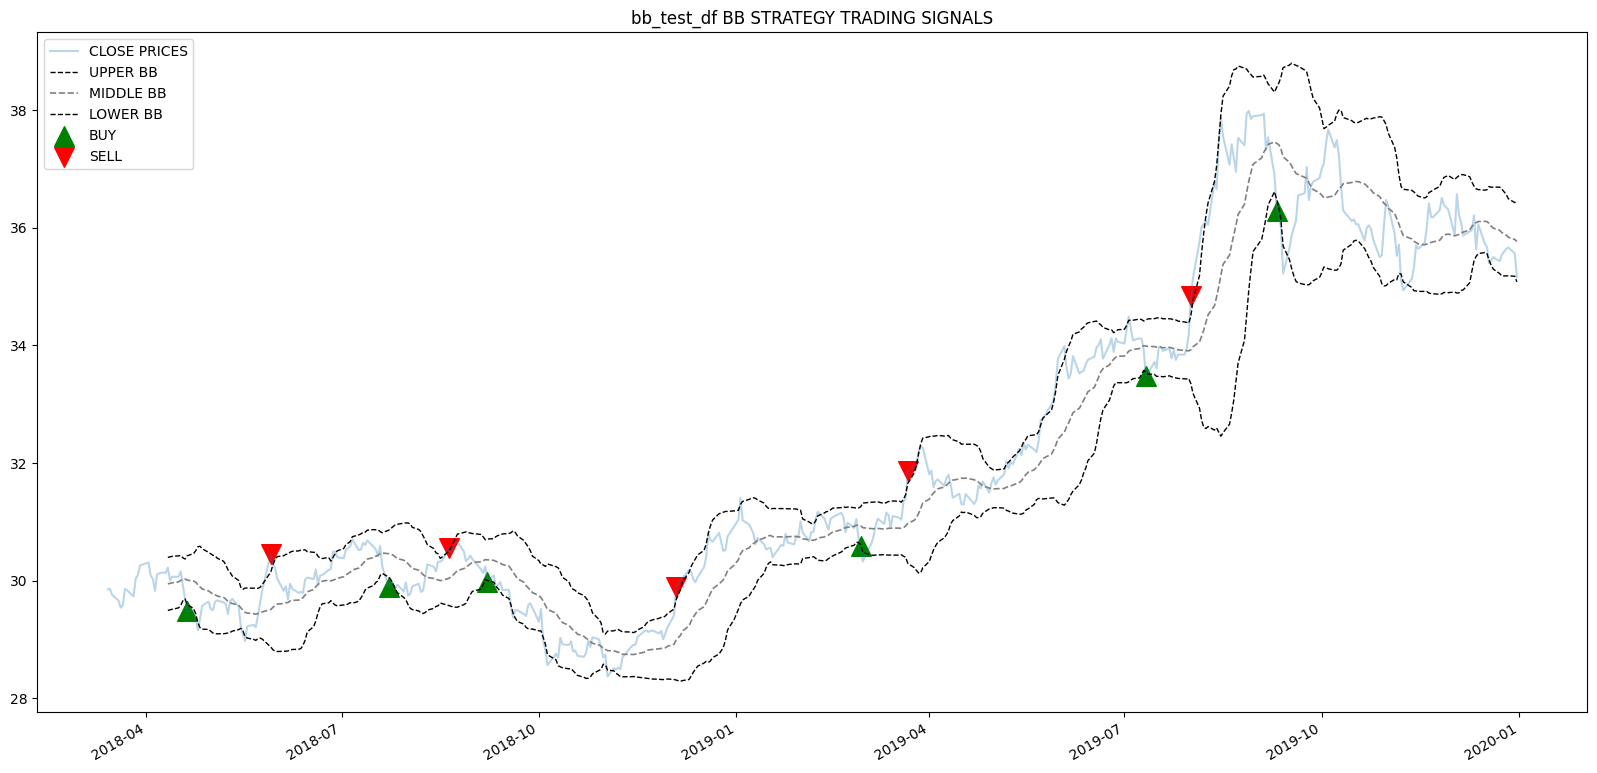

In [21]:
plt.figure(figsize = (20,10))

bb_test_df['Adj Close'].plot(label = 'CLOSE PRICES', alpha = 0.3)
bb_test_df['Upper_band'].plot(label = 'UPPER BB', linestyle = '--', linewidth = 1, color = 'black')
bb_test_df['Moving_avg'].plot(label = 'MIDDLE BB', linestyle = '--', linewidth = 1.2, color = 'grey')
bb_test_df['Lower_band'].plot(label = 'LOWER BB', linestyle = '--', linewidth = 1, color = 'black')
plt.scatter(bb_test_df.index, bb_test_df['buy_price'], marker = '^', color = 'green', label = 'BUY', s = 200)
plt.scatter(bb_test_df.index, bb_test_df['sell_price'], marker = 'v', color = 'red', label = 'SELL', s = 200)
plt.title('bb_test_df BB STRATEGY TRADING SIGNALS')
plt.legend(loc = 'upper left')
plt.show()

In [22]:
def print_buy_sell(df):
    buy_df = df[df['Position'] == 1]
    sell_df = df[df['Position'] == -1]

    combined = pd.concat([buy_df, sell_df])
    return combined.sort_index()

combined = print_buy_sell(bb_test_df)
combined

bb_units = calculate_units(bb_test_df, bb_test_df['Position'], 200000, 10)

bb_units = bb_units.fillna(0)

bb_filtered_units = bb_units.loc[bb_units.index.isin(combined.index)]

print(bb_filtered_units)

bb_filtered_prices = bb_test_df['Adj Close'].loc[bb_test_df['Adj Close'].index.isin(bb_filtered_units.index)]

bb_filtered_units_turnover = bb_filtered_units.replace(0, pd.NA).fillna(method='ffill')

bb_turnover_value = bb_filtered_units_turnover * bb_filtered_prices

bb_theta_t = bb_units * bb_test_df['Adj Close']

bb_pnl_df = (der_test * bb_theta_t)

print("The turnover in dollar value traded over time: ", bb_turnover_value.sum())

print("The turnover in number of units traded over time: ", (bb_filtered_units.sum() * 2) - bb_filtered_units[-1])

2018-04-20    67846.271556
2018-05-29        0.000000
2018-07-23    69133.750754
2018-08-20        0.000000
2018-09-07    70438.474142
2018-12-04        0.000000
2019-02-28    68802.210425
2019-03-22        0.000000
2019-07-11    65494.089436
2019-08-01        0.000000
2019-09-10    62892.993416
dtype: float64
The turnover in dollar value traded over time:  23516185.96541979
The turnover in number of units traded over time:  746322.5860419468


C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1920503791.py:21: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  bb_filtered_units_turnover = bb_filtered_units.replace(0, pd.NA).fillna(method='ffill')
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1920503791.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print("The turnover in number of units traded over time: ", (bb_filtered_units.sum() * 2) - bb_filtered_units[-1])


In [23]:
bb_turnover_df = bb_turnover_value.to_frame()
bb_turnover_df.columns = ['Value']
bb_turnover_df = bb_turnover_df.reindex(bb_units.index)
bb_turnover_df = bb_turnover_df.fillna(0)

bb_units_turnover_df = bb_filtered_units_turnover.to_frame()
bb_units_turnover_df.columns = ['Units']
bb_units_turnover_df = bb_units_turnover_df.reindex(bb_units.index)
bb_units_turnover_df = bb_units_turnover_df.fillna(0)

In [24]:
bb_pnl_df.head(40)

2018-03-14        0.000000
2018-03-15        0.000000
2018-03-16       -0.000000
2018-03-19       -0.000000
2018-03-20       -0.000000
2018-03-21        0.000000
2018-03-22        0.000000
2018-03-23       -0.000000
2018-03-26       -0.000000
2018-03-27        0.000000
2018-03-28        0.000000
2018-03-29        0.000000
2018-04-02        0.000000
2018-04-03       -0.000000
2018-04-04       -0.000000
2018-04-05       -0.000000
2018-04-06        0.000000
2018-04-09        0.000000
2018-04-10       -0.000000
2018-04-11        0.000000
2018-04-12       -0.000000
2018-04-13        0.000000
2018-04-16       -0.000000
2018-04-17        0.000000
2018-04-18       -0.000000
2018-04-19       -0.000000
2018-04-20   -14682.705773
2018-04-23     1038.499038
2018-04-24    -9468.378987
2018-04-25   -13524.285990
2018-04-26    12845.479373
2018-04-27    15221.360299
2018-04-30     4566.038627
2018-05-01    -8618.484057
2018-05-02    -1308.564112
2018-05-03     9307.670074
2018-05-04     1628.160595
2

In [25]:
n_days = len(bb_units)
initial_cash = 200000
leverage = 10

# assets
bb_V_t = np.zeros((n_days,))
bb_delta_V_t = np.zeros((n_days,))

# money market
bb_V_cap = np.zeros((n_days,))
bb_delta_V_cap = np.zeros((n_days,))

# totals
bb_V_total = np.zeros((n_days,))
bb_delta_V_total = np.zeros((n_days,))

# initial values
bb_V_t[0] = initial_cash
bb_delta_V_t[0] = 0
bb_V_cap[0] = 0
bb_delta_V_cap[0] = 0
bb_V_total[0] = bb_V_t[0] + bb_delta_V_cap[0]
bb_delta_V_total[0] = 0

for i, s in enumerate (bb_units[:-1]):
    
    if i == 0:
        continue
        
    # get V_t
    bb_delta_V_t[i] = (der_test[i+1] * bb_theta_t[i]) 
    bb_V_t[i] = bb_delta_V_t[i] + bb_V_t[i-1]
    
    # get V_cap_t
    M = np.abs(bb_theta_t[i]) / leverage
    bb_delta_V_cap[i] = (bb_V_total[i-1] - M) * (test_effr[i+1]) 
    bb_V_cap[i] = bb_delta_V_cap[i] + bb_V_cap[i-1]

    # Get V_total_t
    bb_delta_V_total[i] = bb_pnl_df[i] + bb_delta_V_cap[i]
    bb_V_total[i] = bb_delta_V_total[i] + bb_V_total[i-1]

bb_delta_V_cap = np.abs(bb_delta_V_cap)

C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1487529839.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bb_delta_V_t[i] = (der_test[i+1] * bb_theta_t[i])
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1487529839.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M = np.abs(bb_theta_t[i]) / leverage
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1487529839.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  bb_delta_V

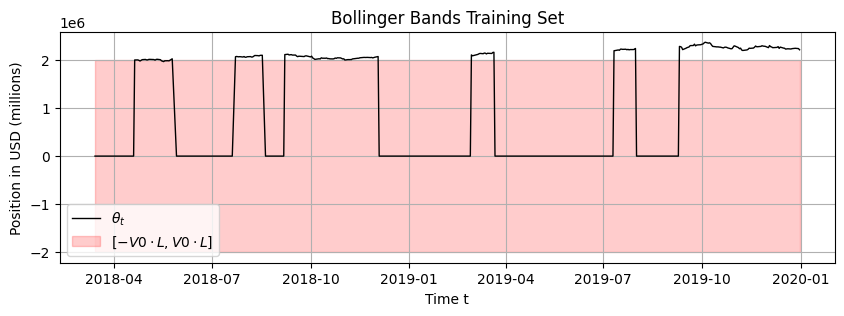

In [26]:
plot_position_strategy(bb_test_df.index, bb_theta_t, "Bollinger Bands Training Set")

### Overnight

In [27]:
on_train_df, on_test_df = train_test_split(df_sptl, test_size = 0.3, shuffle=False)

on_train_df.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)
on_test_df.drop(['High','Low','Adj Close', 'Volume'],axis=1,inplace=True)

In [28]:
on_test_df

,Open,Close,Ascending_Numbers
2018-03-14,34.410000,34.630001,1049
2018-03-15,34.619999,34.639999,1050
2018-03-16,34.520000,34.520000,1051
2018-03-19,34.369999,34.410000,1052
2018-03-20,34.230000,34.270000,1053
...,...,...,...
2019-12-24,39.029999,39.290001,1494
2019-12-26,39.320000,39.389999,1495
2019-12-27,39.459999,39.419998,1496
2019-12-30,39.040001,39.310001,1497


In [29]:
on_test_df['Overnight Return'] = (on_test_df['Open'].shift(-1) - on_test_df['Close']).shift(1)
on_test_df['Overnight Return %'] = ((on_test_df['Open'].shift(-1) - on_test_df['Close']).shift(1)/on_test_df['Close'])*100
on_test_df['Overnight Return %'] = on_test_df['Overnight Return %'].fillna(0)

on_test_df_investment = 200000 * 10
on_test_df_profit = 0
for i in range(1, len(on_test_df)):
    on_test_df_pnl =  (on_test_df['Overnight Return %'][i]/100)* 2000000
    on_test_df_profit = on_test_df_profit + on_test_df_pnl
print('Current Investment Value: ',(on_test_df_investment+on_test_df_profit))
print('Total PnL % :',((on_test_df_profit/2000000)*100).round(3))

Current Investment Value:  2113910.1403673617
Total PnL % : 5.696


C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\3509648488.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  on_test_df_pnl =  (on_test_df['Overnight Return %'][i]/100)* 2000000


In [30]:
def calculate_units_on(sptl_data, initial_capital, leverage):
    units = pd.Series(index=sptl_data.index, dtype='float64')
    cash = initial_capital * leverage
    turnover_value = pd.Series(index=sptl_data.index, dtype='float64')
    for i in range(len(sptl_data)):
        if cash >= sptl_data['Close'].iloc[i]:
            units.iloc[i] = cash / sptl_data['Close'].iloc[i]
            turnover_value.iloc[i] = sptl_data['Close'].iloc[i] * units.iloc[i]
            cash = 0
            continue
        elif cash <= sptl_data['Close'].iloc[i]:
            cash += units.iloc[i-1] * sptl_data['Open'].iloc[i]
            turnover_value.iloc[i] = cash
            units.iloc[i] = 0
            units.iloc[i] = cash / sptl_data['Close'].iloc[i]
            turnover_value.iloc[i] += sptl_data['Close'].iloc[i] * units.iloc[i]
            cash = 0
            continue
        else: 
            units.iloc[i] = units.iloc[i-1]
    return units, turnover_value

#print(calculate_units_on(on_test_df, 200000, 10))

on_test_df['Units Held'], on_turnover = calculate_units_on(on_test_df, 200000, 10)
on_test_df['Daily PnL'] = on_test_df['Units Held'] * on_test_df['Overnight Return']

print(on_test_df.tail())

on_theta_t = on_test_df['Units Held'] * on_test_df['Close']

on_pnl_df = (der_test * on_theta_t)


on_abs_pnl_df = on_pnl_df.abs()

print("The turnover in dollar value traded over time: ", on_turnover.sum())

on_turnover_units = (on_test_df['Units Held'].sum() * 2) - on_test_df['Units Held'][-1]

print("The turnover in number of units traded over time: ", on_turnover_units)

len(on_test_df)

                 Open      Close  Ascending_Numbers  Overnight Return  \
2019-12-24  39.029999  39.290001               1494         -0.130001   
2019-12-26  39.320000  39.389999               1495          0.029999   
2019-12-27  39.459999  39.419998               1496          0.070000   
2019-12-30  39.040001  39.310001               1497         -0.379997   
2019-12-31  39.110001  38.869999               1498         -0.200001   

            Overnight Return %    Units Held     Daily PnL  
2019-12-24           -0.330876  54844.652021  -7129.863343  
2019-12-26            0.076158  54747.187970   1642.348809  
2019-12-27            0.177574  54802.741946   3836.175212  
2019-12-30           -0.966668  54426.329713 -20681.855804  
2019-12-31           -0.514538  54762.383503 -10952.518481  
The turnover in dollar value traded over time:  1854395863.8853636
The turnover in number of units traded over time:  51262253.960035294


C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\1749336430.py:39: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  on_turnover_units = (on_test_df['Units Held'].sum() * 2) - on_test_df['Units Held'][-1]


450

In [31]:
n_days = len(on_test_df)
initial_cash = 200000
leverage = 10

# assets
on_V_t = np.zeros((n_days,))
on_delta_V_t = np.zeros((n_days,))

# money market
on_V_cap = np.zeros((n_days,))
on_delta_V_cap = np.zeros((n_days,))

# totals
on_V_total = np.zeros((n_days,))
on_delta_V_total = np.zeros((n_days,))

# initial values
on_V_t[0] = initial_cash
on_delta_V_t[0] = 0
on_V_cap[0] = 0
on_delta_V_cap[0] = 0
on_V_total[0] = on_V_t[0] + on_delta_V_cap[0]
on_delta_V_total[0] = 0

for i, s in enumerate (on_test_df[:-1]):
    
    if i == 0:
        continue
        
    # get V_t
    on_delta_V_t[i] = (der_test[i+1] * on_theta_t[i]) 
    on_V_t[i] = on_delta_V_t[i] + on_V_t[i-1]
    
    # get V_cap_t
    M = np.abs(on_theta_t[i]) / leverage
    on_delta_V_cap[i] = (on_V_total[i-1] - M) * (test_effr[i+1]) 
    on_V_cap[i] = on_delta_V_cap[i] + on_V_cap[i-1]

    # Get V_total_t
    on_delta_V_total[i] = on_pnl_df[i] + on_delta_V_cap[i]
    on_V_total[i] = on_delta_V_total[i] + on_V_total[i-1]

on_delta_V_cap = np.abs(on_delta_V_cap)

C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2052870975.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  on_delta_V_t[i] = (der_test[i+1] * on_theta_t[i])
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2052870975.py:35: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  M = np.abs(on_theta_t[i]) / leverage
C:\Users\Minec\AppData\Local\Temp\ipykernel_3560\2052870975.py:36: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  on_delta_V

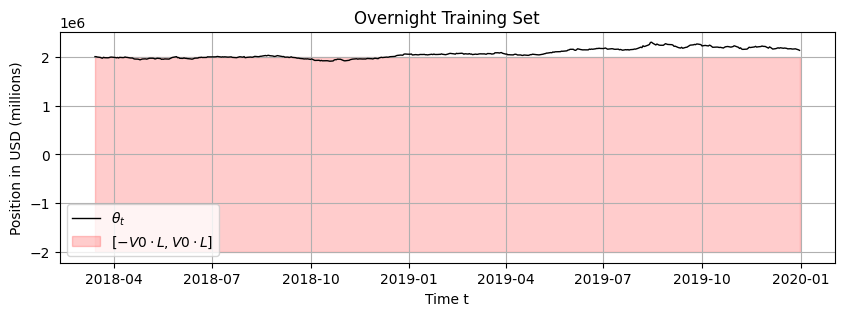

In [32]:
plot_position_strategy(on_test_df.index, on_theta_t, "Overnight Training Set")

## Turnover Moving Average

Text(0.5, 0.98, 'Turnover in dollar value traded over time (USD)')

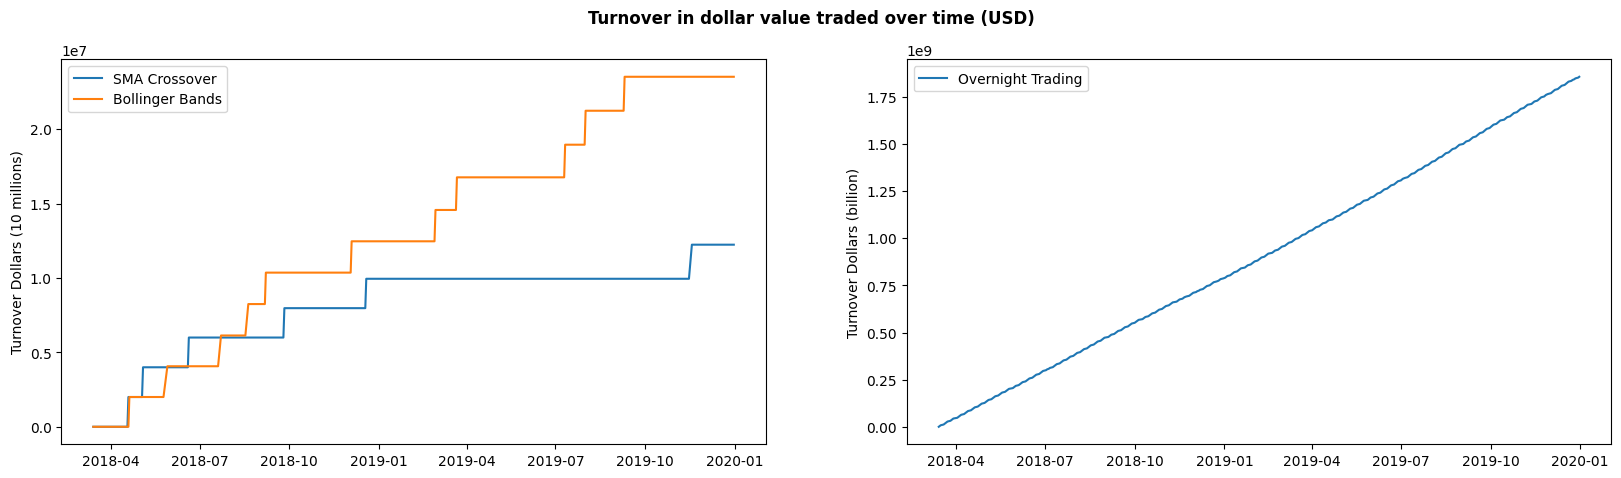

In [33]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5), sharex=False, sharey=False)

ax1.plot(test_df.index, np.cumsum(sma_turnover_df), label = 'SMA Crossover')
ax1.plot(test_df.index, np.cumsum(bb_turnover_df), label = 'Bollinger Bands')
ax1.legend(loc='upper left')
ax1.set_ylabel('Turnover Dollars (10 millions)')

ax2.plot(test_df.index, np.cumsum(on_turnover), label = 'Overnight Trading')
ax2.legend(loc='upper left')
ax2.set_ylabel('Turnover Dollars (billion)')

plt.suptitle('Turnover in dollar value traded over time (USD)', fontweight='bold')

Text(0.5, 0.98, 'Turnover in number of units traded over time')

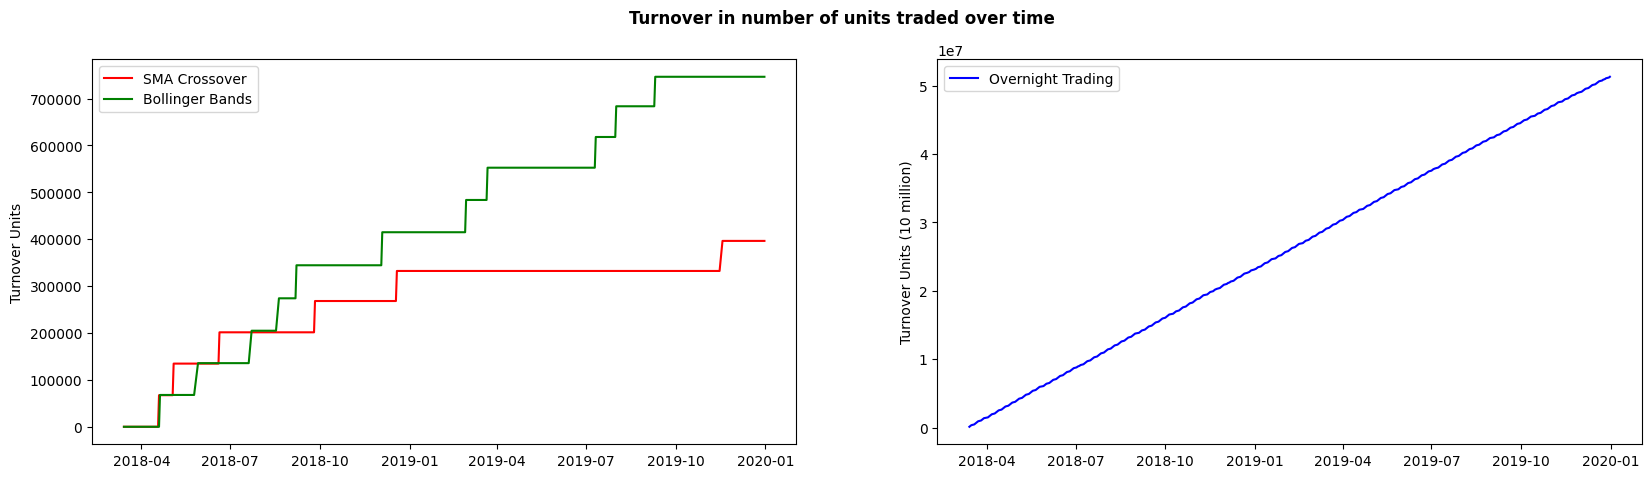

In [34]:
fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(20,5), sharex=False, sharey=False)

ax1.plot(test_df.index, np.cumsum(sma_units_turnover_df), label = 'SMA Crossover', color = 'r')
ax1.plot(test_df.index, np.cumsum(bb_units_turnover_df), label = 'Bollinger Bands', color = 'g')
ax1.legend(loc='upper left')
ax1.set_ylabel('Turnover Units')

ax2.plot(test_df.index, np.cumsum((on_test_df['Units Held']*2)), label = 'Overnight Trading', color = 'b')
ax2.legend(loc='upper left')
ax2.set_ylabel('Turnover Units (10 million)')

plt.suptitle('Turnover in number of units traded over time', fontweight='bold')

## Total PnL Series

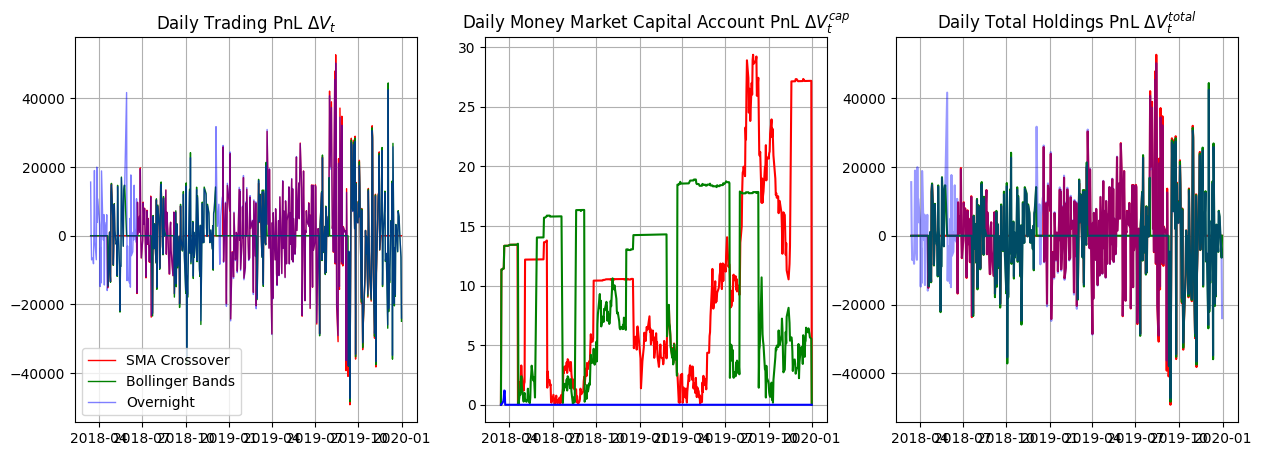

In [35]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize = (15,5))

ax1.plot(test_df.index, sma_pnl_df, color = "r", lw = 1, label = 'SMA Crossover')
ax1.plot(test_df.index, bb_pnl_df, color = "g", lw = 1, label = 'Bollinger Bands')
ax1.plot(test_df.index, on_pnl_df, color = "b", lw = 1, alpha = 0.5, label = 'Overnight')
ax1.set_title(r'Daily Trading PnL $\Delta V_t$')
ax1.grid(True)
ax1.legend(loc='lower left', frameon=True)

ax2.plot(test_df.index, sma_delta_V_cap, color='r')
ax2.plot(test_df.index, bb_delta_V_cap, color ='g')
ax2.plot(test_df.index, on_delta_V_cap, color ='b')
ax2.set_title(r'Daily Money Market Capital Account PnL $\Delta V_t^{cap}$')
ax2.grid(True)

ax3.plot(test_df.index, sma_delta_V_total, color ='r')
ax3.plot(test_df.index, bb_delta_V_total, color ='g')
ax3.plot(test_df.index, on_pnl_df, color ='b', alpha = 0.4)
ax3.set_title(r'Daily Total Holdings PnL $\Delta V_t^{total}$')
ax3.grid(True)

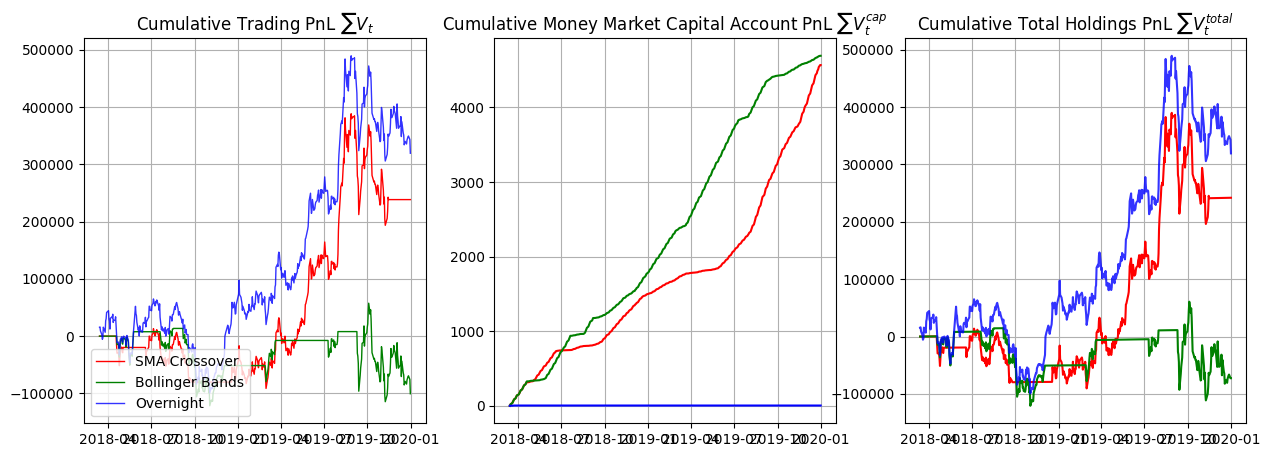

In [36]:
fig, ((ax1, ax2, ax3)) = plt.subplots(nrows=1, ncols=3, sharex=True, figsize = (15,5))

ax1.plot(test_df.index, np.cumsum(sma_pnl_df), color = "r", lw = 1, label = 'SMA Crossover')
ax1.plot(test_df.index, np.cumsum(bb_pnl_df), color = "g", lw = 1, label = 'Bollinger Bands')
ax1.plot(test_df.index, np.cumsum(on_pnl_df), color = "b", lw = 1, alpha = 0.8, label = 'Overnight')
ax1.set_title(r'Cumulative Trading PnL $\sum V_t$')
ax1.grid(True)
ax1.legend(loc='lower left', frameon=True)

ax2.plot(test_df.index, np.cumsum(sma_delta_V_cap), color='r')
ax2.plot(test_df.index, np.cumsum(bb_delta_V_cap), color ='g')
ax2.plot(test_df.index, np.cumsum(on_delta_V_cap), color ='b')
ax2.set_title(r'Cumulative Money Market Capital Account PnL $\sum V_t^{cap}$')
ax2.grid(True)

ax3.plot(test_df.index, np.cumsum(sma_delta_V_total), color ='r')
ax3.plot(test_df.index, np.cumsum(bb_delta_V_total), color ='g')
ax3.plot(test_df.index, np.cumsum(on_pnl_df), color ='b', alpha = 0.8)
ax3.set_title(r'Cumulative Total Holdings PnL $\sum V_t^{total}$')
ax3.grid(True)

# Performance Indicators

In [37]:
def calculate_performance_metrics(excess_returns):
    
    # Sharpe Ratio
    sharpe_ratio = (np.mean(excess_returns) / np.std(excess_returns)) * np.sqrt(252)
    
    # Sortino Ratio
    sortino_ratio = (np.mean(excess_returns) / np.std(excess_returns[excess_returns < 0])) * np.sqrt(252)
    
    # Maximum Drawdown
    temp = excess_returns.pct_change().dropna()
    temp[np.isinf(temp)] = 0

    cumulative_returns = (1 + temp).cumprod()
    high_water_mark = np.maximum.accumulate(cumulative_returns)
    drawdowns = (cumulative_returns - high_water_mark) / high_water_mark
    max_drawdown = np.min(drawdowns)
    
    # Calmar Ratio
    annual_return = np.mean(excess_returns) * 252
    if max_drawdown == 0:
        print("Max drawdown is zero, Calmar ratio is undefined.")
        calmar_ratio = np.nan
    else:
        calmar_ratio = np.sum(temp) / abs(max_drawdown)
    
    print("Sharpe: ", sharpe_ratio)
    print("Sortino: ", sortino_ratio)
    print(f"Maximum Drawdown: {max_drawdown*10:.2f}%")
    print("Calmar: ", calmar_ratio)


print("TEST Sets")
print("\nSMA Crossover")
calculate_performance_metrics(sma_pnl_df)

#calculate_performance_metrics(sma_excess)
print("\nBollinger Bands")
calculate_performance_metrics(bb_pnl_df)

print("\nOvernight")
calculate_performance_metrics(on_pnl_df)


TEST Sets

SMA Crossover
Sharpe:  0.6969384944166832
Sortino:  0.8682102126028122
Maximum Drawdown: -19.97%
Calmar:  -77.27926090656628

Bollinger Bands
Sharpe:  -0.3592273298154912
Sortino:  -0.34768563701454686
Maximum Drawdown: -20.37%
Calmar:  -54.277611202742804

Overnight
Sharpe:  0.8202192163176131
Sortino:  1.2702689979174442
Maximum Drawdown: -185.59%
Calmar:  -26.055804199924932


## Rolling Sharpe Ratio

<Axes: >

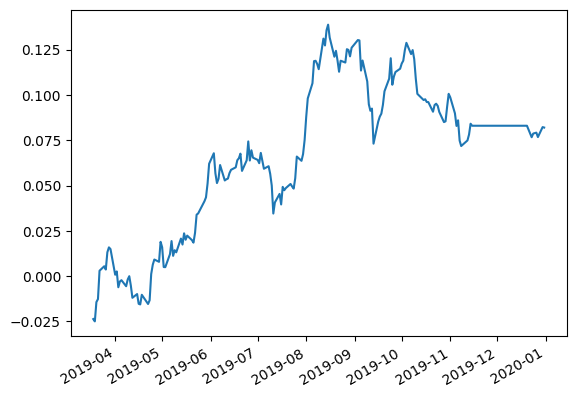

In [38]:
rolling_window = 252
excess_returns = sma_pnl_df

rolling_sharpe_ratio = excess_returns.rolling(window=rolling_window).mean() / excess_returns.rolling(window=rolling_window).std()


rolling_sharpe_ratio.plot()

## Drawdown Chart

Text(0.93, 0.5, 'Asset Volatility')

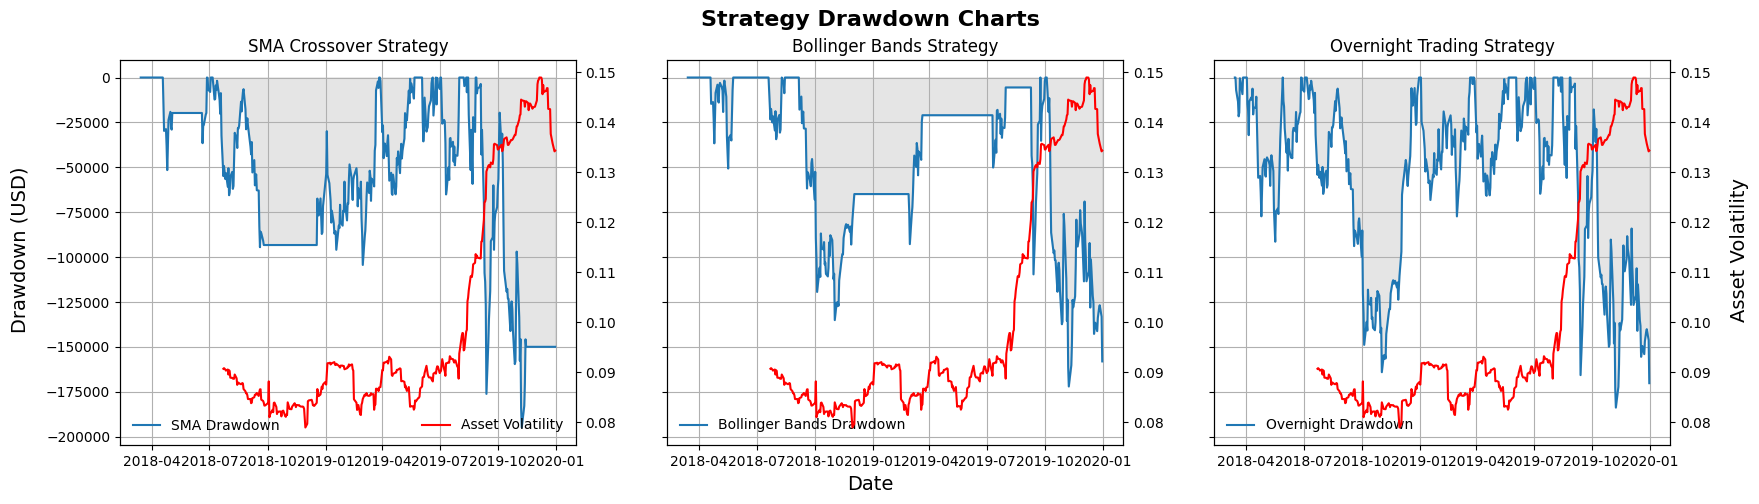

In [39]:
sma_cum_pnl = np.cumsum(sma_pnl_df)
sma_drawdown = sma_cum_pnl - np.maximum.accumulate(sma_cum_pnl)

bb_cum_pnl = np.cumsum(bb_pnl_df)
bb_drawdown = bb_cum_pnl - np.maximum.accumulate(bb_cum_pnl)

on_cum_pnl = np.cumsum(on_pnl_df)
on_drawdown = on_cum_pnl - np.maximum.accumulate(on_cum_pnl)

rolling_volatility = test_df['Adj Close'].pct_change().rolling(window=90).std() * np.sqrt(252)

fig, ((ax1, ax2, ax3)) = plt.subplots(1, 3, figsize=(20,5), sharey=True)

ax1.plot(test_df.index, sma_drawdown, label='SMA Drawdown')
ax1.fill_between(test_df.index, sma_drawdown, alpha=0.2, color='grey')
ax1.grid(True)
ax1.legend(loc='lower left', frameon=False)

ax1_vol = ax1.twinx()
ax1_vol.plot(test_df.index, rolling_volatility, color='red', label='Asset Volatility')
ax1_vol.legend(loc='lower right', frameon=False)

ax1.set_title('SMA Crossover Strategy')


ax2.plot(test_df.index, bb_drawdown, label='Bollinger Bands Drawdown')
ax2.fill_between(test_df.index, bb_drawdown, alpha=0.2, color='grey')
ax2.grid(True)
ax2.legend(loc='lower left', frameon=False)

ax2_vol = ax2.twinx()
ax2_vol.plot(test_df.index, rolling_volatility, color='red', label='Asset Volatility')

ax2.set_title('Bollinger Bands Strategy')


ax3.plot(test_df.index, on_drawdown, label='Overnight Drawdown')
ax3.fill_between(test_df.index, on_drawdown, alpha=0.2, color='grey')
ax3.grid(True)
ax3.legend(loc='lower left', frameon=False)

ax3_vol = ax3.twinx()
ax3_vol.plot(test_df.index, rolling_volatility, color='red', label='Asset Volatility')

ax3.set_title('Overnight Trading Strategy')


plt.suptitle('Strategy Drawdown Charts', fontsize=16, fontweight='bold')
fig.text(0.5, 0.02, 'Date', ha='center', fontsize=14)
fig.text(0.07, 0.5, 'Drawdown (USD)', va='center', rotation='vertical', fontsize=14)
fig.text(0.93, 0.5, 'Asset Volatility', va='center', rotation='vertical', fontsize=14)